In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd

In [81]:
import matplotlib.patches as mpatches

In [150]:
import sys
sys.path.append("../")
from plotting import ms_color, hc_color, get_area_relevance
from config import *

In [4]:
# paths
train_brain_h5 = h5py.File("/analysis/fabiane/data/MS/explMS/train_dataset_brain_masks_fullres.h5")
holdout_brain_h5 = h5py.File("/analysis/fabiane/data/MS/explMS/holdout_dataset_brain_masks_fullres.h5")
train_lesions_h5 = h5py.File("/analysis/fabiane/data/MS/explMS/train_dataset_lesions_fullres.h5")
holdout_lesions_h5 = h5py.File("/analysis/fabiane/data/MS/explMS/holdout_dataset_lesions_fullres.h5")

In [6]:
df = pd.read_csv("/analysis/fabiane/data/MS/explMS/file_list_HC_MS_BET_FLAIR.csv")

In [7]:
df.iloc[85:95]

,file,label,name,path,time
85,VIMS_MS_079_1_FLAIR.nii.gz,MS,VIMS_MS_079,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_07...,1.0
86,VIMS_MS_046_1_FLAIR.nii.gz,MS,VIMS_MS_046,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_04...,1.0
87,VIMS_MS_049_1_FLAIR.nii.gz,MS,VIMS_MS_049,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_04...,1.0
88,RS_GK_005_1_FLAIR.nii.gz,HC,RS_GK_005,/analysis/share/Ritter/MS/CIS/02_HC/RS_GK_005/...,1.0
89,VIMS_MS_072_1_FLAIR.nii.gz,MS,VIMS_MS_072,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_07...,1.0
90,VIMS_HC_097_1_FLAIR.nii.gz,HC,VIMS_HC_097,/analysis/share/Ritter/MS/CIS/02_HC/VIMS_HC_09...,1.0
91,VIMS_MS_001_1_FLAIR.nii.gz,MS,VIMS_MS_001,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_00...,1.0
92,RS_GK_023_1_FLAIR.nii.gz,HC,RS_GK_023,/analysis/share/Ritter/MS/CIS/02_HC/RS_GK_023/...,1.0
93,VIMS_MS_041_1_FLAIR.nii.gz,MS,VIMS_MS_041,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_04...,1.0
94,RS_GK_006_1_FLAIR.nii.gz,HC,RS_GK_006,/analysis/share/Ritter/MS/CIS/02_HC/RS_GK_006/...,1.0


In [8]:
lesion_masks_train = train_lesions_h5['masks']
lesion_masks_holdout = holdout_lesions_h5['masks']

In [9]:
brain_masks_train = train_brain_h5['masks']
brain_masks_holdout = holdout_brain_h5['masks']

In [10]:
np.max(lesion_masks_train)

1.0

In [11]:
np.max(lesion_masks_holdout)

1.0

In [12]:
len(lesion_masks_train)

124

In [13]:
# split dataframe
holdout_df = df.iloc[indices_holdout].reset_index()
train_df = df.drop(indices_holdout).reset_index()

In [14]:
train_df.groupby("label").count()

,index,file,name,path,time
label,,,,,
HC,61,61,61,61,61
MS,63,63,63,63,63


In [15]:
holdout_df.groupby("label").count()

,index,file,name,path,time
label,,,,,
HC,10,10,10,10,10
MS,13,13,13,13,13


# Lesion ratios

In [16]:
# calculate ratio of all subjects with lesions
lesion_ratio = []
lesion_sum = []
lesion_sum_hc = []
lesion_sum_ms = []

for idx, row in train_df.iterrows():
    lm, bm = lesion_masks_train[idx], brain_masks_train[idx]
    if np.sum(lm) > 0:
        # catch scans without lesion masks i.e. contain random info
        if np.max(lm) != 1 and np.max(lm) != 0 and np.min(lm) != 0:
            print("No lesion mask")
        else:
            ratio = np.sum(lm)/np.sum(bm)
            lesion_ratio.append(ratio)
            lesion_sum.append(np.sum(lm))
            if row["label"] == "MS":
                lesion_sum_ms.append(np.sum(lm))
            else:
                lesion_sum_hc.append(np.sum(lm))

for idx, row in holdout_df.iterrows():
    lm, bm = lesion_masks_holdout[idx], brain_masks_holdout[idx]
    if np.sum(lm) > 0:
        # catch scans without lesion masks i.e. contain random info
        if np.max(lm) != 1 and np.max(lm) != 0 and np.min(lm) != 0:
            print("No lesion mask")
        else:
            ratio = np.sum(lm)/np.sum(bm)
            lesion_ratio.append(ratio)
            lesion_sum.append(np.sum(lm))
            if row["label"] == "MS":
                lesion_sum_ms.append(np.sum(lm))
            else:
                lesion_sum_hc.append(np.sum(lm))
    
print(np.mean(lesion_ratio))

No lesion mask
No lesion mask
No lesion mask
No lesion mask
0.004380442567354902


In [17]:
np.max(lesion_ratio)

0.05145555500148515

In [18]:
np.min(lesion_ratio)

7.279298494004132e-06

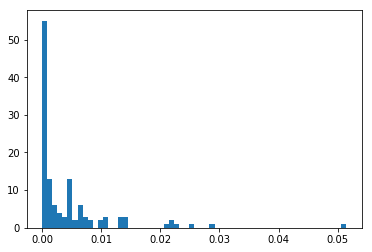

In [19]:
plt.hist(lesion_ratio, bins=60)
plt.show()

In [20]:
print("Mean lesion ratio {:.4f} %".format(np.mean(lesion_ratio) * 100))
print("Std lesion ratio {:.4f} %".format(np.std(lesion_ratio) * 100))
print("Max lesion ratio {:.4f} %".format(np.max(lesion_ratio) * 100))
print("Min lesion ratio {:.4f} %".format(np.min(lesion_ratio) * 100))

Mean lesion ratio 0.4380 %
Std lesion ratio 0.7160 %
Max lesion ratio 5.1456 %
Min lesion ratio 0.0007 %


In [21]:
# calculate sums of all subjects
lesion_sum = []
lesion_sum_hc = []
lesion_sum_ms = []

for idx, row in train_df.iterrows():
    lm, bm = lesion_masks_train[idx], brain_masks_train[idx]
    # catch scans without lesion masks i.e. contain random info
    if np.max(lm) != 1 and np.max(lm) != 0 and np.min(lm) != 0:
        print("No lesion mask in training. abel: {}".format(row["label"]))
    else:
        lesion_sum.append(np.sum(lm))
        if row["label"] == "MS":
            lesion_sum_ms.append(np.sum(lm))
        else:
            lesion_sum_hc.append(np.sum(lm))

for idx, row in holdout_df.iterrows():
    lm, bm = lesion_masks_holdout[idx], brain_masks_holdout[idx]
    # catch scans without lesion masks i.e. contain random info
    if np.max(lm) != 1 and np.max(lm) != 0 and np.min(lm) != 0:
        print("No lesion mask in holdout")
    else:
        lesion_sum.append(np.sum(lm))
        if row["label"] == "MS":
            lesion_sum_ms.append(np.sum(lm))
        else:
            lesion_sum_hc.append(np.sum(lm))

No lesion mask in training. abel: MS
No lesion mask in training. abel: MS
No lesion mask in training. abel: HC
No lesion mask in training. abel: HC


In [22]:
print("Mean lesion sum {:.2f}".format(np.mean(lesion_sum)))
print("Std lesion sum {:.2f}".format(np.std(lesion_sum)))
print("Max lesion sum {:.2f}".format(np.max(lesion_sum)))
print("Min lesion sum {:.2f}".format(np.min(lesion_sum)))

Mean lesion sum 4044.76
Std lesion sum 6851.58
Max lesion sum 47466.00
Min lesion sum 0.00


In [23]:
print("Mean lesion sum HC {:.2f}".format(np.mean(lesion_sum_hc)))
print("Std lesion sum HC {:.2f}".format(np.std(lesion_sum_hc)))
print("Max lesion sum HC {:.2f}".format(np.max(lesion_sum_hc)))
print("Min lesion sum HC {:.2f}".format(np.min(lesion_sum_hc)))

Mean lesion sum HC 571.78
Std lesion sum HC 1941.21
Max lesion sum HC 14977.00
Min lesion sum HC 0.00


In [24]:
print("Mean lesion sum MS {:.2f}".format(np.mean(lesion_sum_ms)))
print("Std lesion sum MS {:.2f}".format(np.std(lesion_sum_ms)))
print("Max lesion sum MS {:.2f}".format(np.max(lesion_sum_ms)))
print("Min lesion sum MS {:.2f}".format(np.min(lesion_sum_ms)))

Mean lesion sum MS 7283.08
Std lesion sum MS 8091.32
Max lesion sum MS 47466.00
Min lesion sum MS 121.00


In [25]:
len(lesion_sum_ms)

74

In [26]:
len(lesion_sum_hc)

69

# Lesion area distribution

In [27]:
from utils import load_nifti, heatmap_per_region, aggregate_regions

In [37]:
wm_atlas_path = "/analysis/fabiane/atlases/JHU/JHU-ICBM-labels-1mm.nii.gz"
wm_atlas = load_nifti(wm_atlas_path)

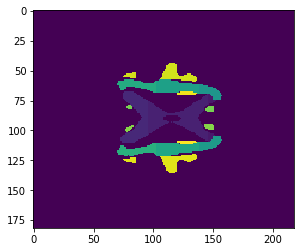

In [38]:
plt.imshow(wm_atlas[:,:,96])
plt.show()

In [139]:
shape = (182, 218, 182)

In [145]:
def get_lesion_sum(list_not_sum=False):
    if not list_not_sum:
        # calculate sums of all subjects over both datasets!
        lesion_sum = np.zeros(shape=shape)
        lesion_sum_hc = np.zeros(shape=shape)
        lesion_sum_ms = np.zeros(shape=shape)
    else:
        lesion_sum = []
        lesion_sum_hc = []
        lesion_sum_ms = []

    for idx, row in train_df.iterrows():
        lm, bm = lesion_masks_train[idx], brain_masks_train[idx]
        # catch scans without lesion masks i.e. contain random info
        if np.max(lm) != 1 and np.max(lm) != 0 and np.min(lm) != 0:
            print("No lesion mask in training. Label: {}".format(row["label"]))
        else:
            if not list_not_sum:
                lesion_sum += lm
            else:
                lesion_sum.append(lm)
            if row["label"] == "MS":
                if not list_not_sum:
                    lesion_sum_ms += lm
                else:
                    lesion_sum_ms.append(lm)
            else:
                if not list_not_sum:
                    lesion_sum_hc += lm
                else:
                    lesion_sum_hc.append(lm)

    for idx, row in holdout_df.iterrows():
        lm, bm = lesion_masks_holdout[idx], brain_masks_holdout[idx]
        # catch scans without lesion masks i.e. contain random info
        if np.max(lm) != 1 and np.max(lm) != 0 and np.min(lm) != 0:
            print("No lesion mask in holdout")
        else:
            if not list_not_sum:
                lesion_sum += lm
            else:
                lesion_sum.append(lm)
            if row["label"] == "MS":
                if not list_not_sum:
                    lesion_sum_ms += lm
                else:
                    lesion_sum_ms.append(lm)
            else:
                if not list_not_sum:
                    lesion_sum_hc += lm
                else:
                    lesion_sum_hc.append(lm)
    return lesion_sum, lesion_sum_ms, lesion_sum_hc

In [146]:
lesion_sum, lesion_sum_ms, lesion_sum_hc = get_lesion_sum()

No lesion mask in training. Label: MS
No lesion mask in training. Label: MS
No lesion mask in training. Label: HC
No lesion mask in training. Label: HC


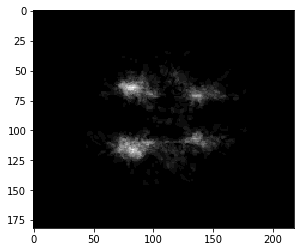

In [147]:
plt.imshow(lesion_sum_ms[:,:,96], cmap='gray')

In [63]:
# Summary of JHU white matter areas
# Name: (min, max)
all_areas= {
    "Middle cerebellar peduncle": (1, 2),
    "Corpus callosum": (3, 5),
    "Fornix": (6, 6),
    "Corticospinal tract": (7, 8),
    "Medial lemniscus": (9, 10),
    "Inferior cerebellar peduncle": (11, 12),
    "Superior cerebellar peduncle": (13, 14),
    "Cerebral peduncle": (15, 16),
    "Anterior limb of internal capsule": (17, 18),
    "Posterior limb of internal capsule": (19, 20),
    "Retrolenticular part of internal capsule": (21, 22),
    "Anterior corona radiata": (23, 24),
    "Superior corona radiata": (25, 26),
    "Posterior corona radiata": (27, 28),
    "Posterior thalamic radiation": (29, 30),
    "Sagittal stratum": (31, 32),
    "External capsule": (33, 34),
    "Cingulum": (35, 38),
    "Superior longitudinal fasciculus": (41, 42),
    "Superior fronto-occipital fasciculus": (43, 44),
    "Uncinate fasciculus": (45, 46),
    "Tapetum": (47, 48),   
}

Absolute values

In [90]:
regional_lm = heatmap_per_region(lesion_sum_ms, wm_atlas, positive=True, size_normalize=False)
area_lm = aggregate_regions(regional_lm, all_areas)
# sort values
area_lm_sorted_ms = sorted(area_lm.items(), key=lambda kv: kv[1])
keys_sorted_ms = [row[0] for row in area_lm_sorted]
values_sorted_ms = [row[1] for row in area_lm_sorted]

regional_lm = heatmap_per_region(lesion_sum_hc, wm_atlas, positive=True, size_normalize=False)
area_lm = aggregate_regions(regional_lm, all_areas)
# sort values
area_lm_sorted_hc = sorted(area_lm.items(), key=lambda kv: kv[1])
keys_sorted_hc = [row[0] for row in area_lm_sorted]
values_sorted_hc = [row[1] for row in area_lm_sorted]


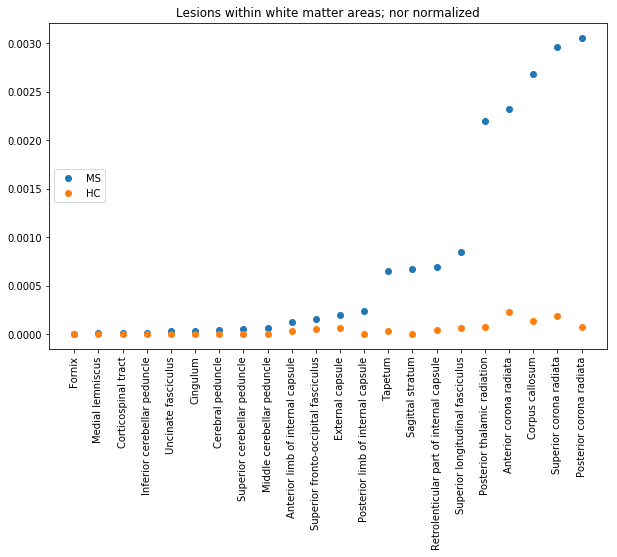

In [73]:
plt.figure(figsize=(10, 6))
plt.plot(keys_sorted_ms, values_sorted_ms, 'o', color=ms_color, label="MS")
plt.plot(keys_sorted_hc, values_sorted_hc, 'o', color=hc_color,  label="HC")
plt.xticks(rotation='vertical')
plt.legend(loc="center left")
plt.title("Lesions within white matter areas; nor normalized")
plt.show()

In [106]:
dict(area_lm_sorted_ms)

{'Fornix': 8.309061641050753e-07,
 'Medial lemniscus': 1.0940264494050158e-05,
 'Corticospinal tract': 1.1147991035076427e-05,
 'Inferior cerebellar peduncle': 1.1355717576102697e-05,
 'Uncinate fasciculus': 2.7350661235125395e-05,
 'Cingulum': 3.0397317170177336e-05,
 'Cerebral peduncle': 4.701544045227884e-05,
 'Superior cerebellar peduncle': 4.805407315741018e-05,
 'Middle cerebellar peduncle': 5.9132822012144526e-05,
 'Anterior limb of internal capsule': 0.00012858272889526042,
 'Superior fronto-occipital fasciculus': 0.00015316370291670222,
 'External capsule': 0.00020149474479548075,
 'Posterior limb of internal capsule': 0.00023445402263831542,
 'Tapetum': 0.0006523998231831682,
 'Sagittal stratum': 0.0006737956569088739,
 'Retrolenticular part of internal capsule': 0.0006969225451431318,
 'Superior longitudinal fasciculus': 0.0008462779281410192,
 'Posterior thalamic radiation': 0.002192830609253636,
 'Anterior corona radiata': 0.0023160816902625552,
 'Corpus callosum': 0.00268

In [128]:
pd.DataFrame(dict(area_lm_sorted_ms), index=["MS"])

,Fornix,Medial lemniscus,Corticospinal tract,Inferior cerebellar peduncle,Uncinate fasciculus,Cingulum,Cerebral peduncle,Superior cerebellar peduncle,Middle cerebellar peduncle,Anterior limb of internal capsule,...,Posterior limb of internal capsule,Tapetum,Sagittal stratum,Retrolenticular part of internal capsule,Superior longitudinal fasciculus,Posterior thalamic radiation,Anterior corona radiata,Corpus callosum,Superior corona radiata,Posterior corona radiata
MS,8.309062e-07,0.000011,0.000011,0.000011,0.000027,0.00003,0.000047,0.000048,0.000059,0.000129,...,0.000234,0.000652,0.000674,0.000697,0.000846,0.002193,0.002316,0.00268,0.002965,0.003057


In [131]:
df_ms = pd.DataFrame(dict(area_lm_sorted_ms), index=["MS"])
df_hc = pd.DataFrame(dict(area_lm_sorted_hc), index=["HC"])
df = df_ms.append(df_hc)

In [132]:
df

,Anterior corona radiata,Anterior limb of internal capsule,Cerebral peduncle,Cingulum,Corpus callosum,Corticospinal tract,External capsule,Fornix,Inferior cerebellar peduncle,Medial lemniscus,...,Posterior limb of internal capsule,Posterior thalamic radiation,Retrolenticular part of internal capsule,Sagittal stratum,Superior cerebellar peduncle,Superior corona radiata,Superior fronto-occipital fasciculus,Superior longitudinal fasciculus,Tapetum,Uncinate fasciculus
MS,0.002316,0.000129,0.000047,0.000030,0.002680,1.114799e-05,0.000201,8.309062e-07,0.000011,0.000011,...,0.000234,0.002193,0.000697,0.000674,0.000048,0.002965,0.000153,0.000846,0.000652,2.735066e-05
HC,0.000229,0.000035,0.000000,0.000001,0.000135,9.693905e-07,0.000061,0.000000e+00,0.000000,0.000000,...,0.000005,0.000078,0.000045,0.000006,0.000000,0.000186,0.000048,0.000065,0.000034,3.462109e-07


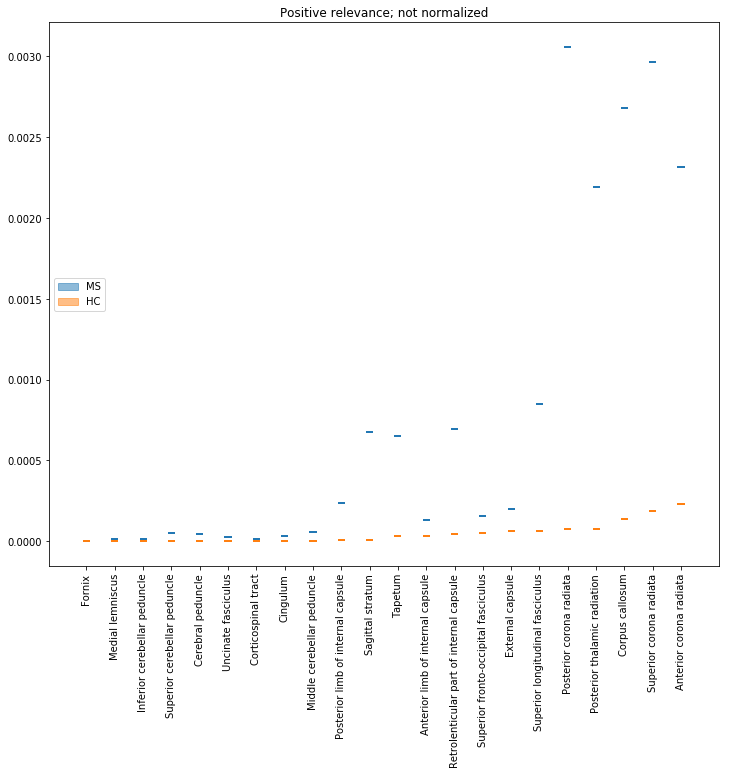

In [133]:
#plt.figure()
fig, axes = plt.subplots(figsize=(12, 10))
axes.violinplot(dataset=[df_ms[key].values.astype(np.float) for key in keys_sorted_ms], showmeans=True)
axes.violinplot(dataset=[df_hc[key].values.astype(np.float) for key in keys_sorted_ms], showmeans=True)

axes.set_xticks(range(1, len(keys_sorted_ms)+1))
axes.set_xticklabels([key for key in keys_sorted_ms])
plt.xticks(rotation='vertical')
ms_patch = mpatches.Patch(color=ms_color, alpha=0.5)
hc_patch = mpatches.Patch(color=hc_color, alpha=0.5)
axes.legend([ms_patch, hc_patch], ["MS", "HC"], loc="center left")
plt.title("Positive relevance; not normalized")
plt.show()

Normalized by size

In [66]:
regional_lm = heatmap_per_region(lesion_sum_ms, wm_atlas, positive=True, size_normalize=True)
area_lm = aggregate_regions(regional_lm, all_areas)
# sort values
area_lm_sorted_ms = sorted(area_lm.items(), key=lambda kv: kv[1])
keys_sorted_ms = [row[0] for row in area_lm_sorted]
values_sorted_ms = [row[1] for row in area_lm_sorted]

regional_lm = heatmap_per_region(lesion_sum_hc, wm_atlas, positive=True, size_normalize=True)
area_lm = aggregate_regions(regional_lm, all_areas)
# sort values
area_lm_sorted_hc = sorted(area_lm.items(), key=lambda kv: kv[1])
keys_sorted_hc = [row[0] for row in area_lm_sorted]
values_sorted_hc = [row[1] for row in area_lm_sorted]


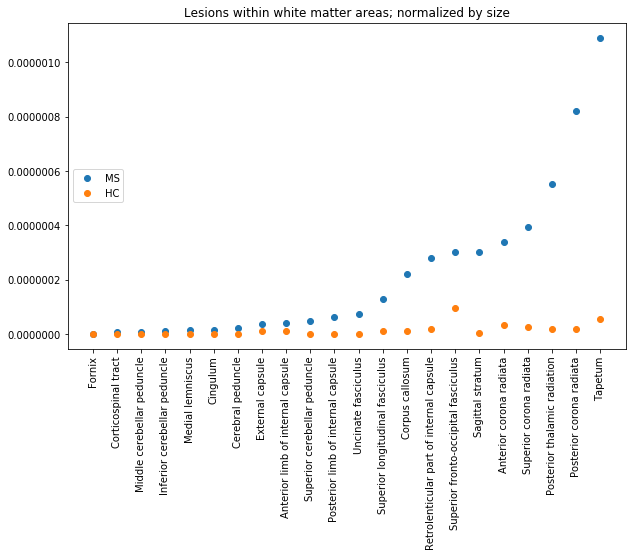

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(keys_sorted_ms, values_sorted_ms, 'o', color=ms_color, label="MS")
plt.plot(keys_sorted_hc, values_sorted_hc, 'o', color=hc_color,  label="HC")
plt.xticks(rotation='vertical')
plt.legend(loc="center left")
plt.title("Lesions within white matter areas; normalized by size")
plt.show()

# Violin plots

In [148]:
lesion_sum, lesion_sum_ms, lesion_sum_hc = get_lesion_sum(list_not_sum=True)

No lesion mask in training. Label: MS
No lesion mask in training. Label: MS
No lesion mask in training. Label: HC
No lesion mask in training. Label: HC


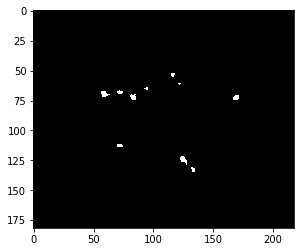

In [149]:
# individual lesion mask
plt.imshow(lesion_sum_ms[0][:,:,96], cmap='gray')

In [152]:
keys_sorted_ms, values_sorted_ms = get_area_relevance(lesion_sum_ms, wm_atlas, all_areas, positive=True, size_normalize=False)

In [161]:
keys_sorted_hc, values_sorted_hc = get_area_relevance(lesion_sum_hc, wm_atlas, all_areas, positive=True, size_normalize=False)

In [162]:
hm_distrib_ms = {}
for key, ind_value in zip(keys_sorted_ms, values_sorted_ms):
    for area, value in zip(key, ind_value):
        if area in hm_distrib_ms.keys():
            hm_distrib_ms[area].append(value)
        else:
            hm_distrib_ms[area] = [value,]
            
hm_distrib_hc = {}
for key, ind_value in zip(keys_sorted_hc, values_sorted_hc):
    for area, value in zip(key, ind_value):
        if area in hm_distrib_hc.keys():
            hm_distrib_hc[area].append(value)
        else:
            hm_distrib_hc[area] = [value,]

In [163]:
df_ms = pd.DataFrame(hm_distrib_ms)
df_hc = pd.DataFrame(hm_distrib_hc)

In [172]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# set serif font
plt.rc('font', family='serif')

Not normalized

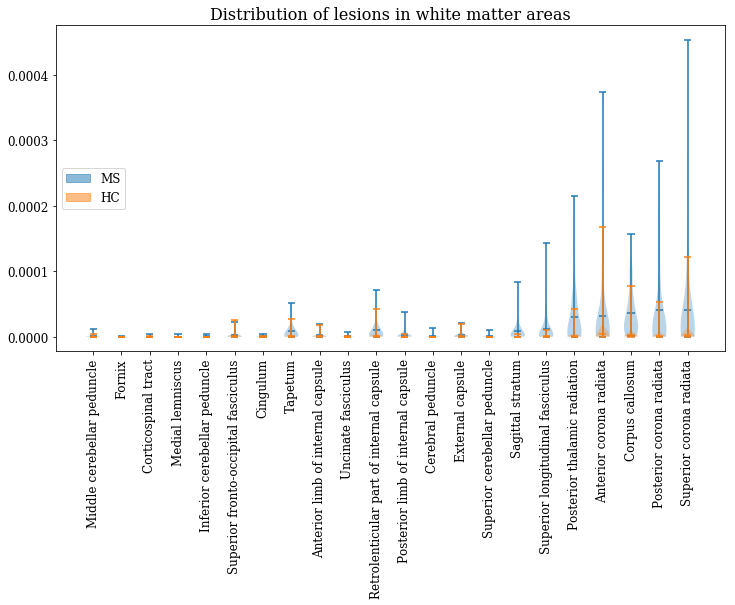

In [177]:
#plt.figure()
fig, axes = plt.subplots(figsize=(12, 6))
axes.violinplot(dataset=[df_ms[key] for key in keys_sorted_ms[0]], showmeans=True)
axes.violinplot(dataset=[df_hc[key] for key in keys_sorted_ms[0]], showmeans=True)

axes.set_xticks(range(1, len(keys_sorted_ms[0])+1))
axes.set_xticklabels([key for key in keys_sorted_ms[0]])
plt.xticks(rotation='vertical')
ms_patch = mpatches.Patch(color=ms_color, alpha=0.5)
hc_patch = mpatches.Patch(color=hc_color, alpha=0.5)
axes.legend([ms_patch, hc_patch], ["MS", "HC"], loc="center left")
plt.title("Distribution of lesions in white matter areas")
plt.show()